# Active Contours

## Active Contours using Parametric Curves

In [1]:
from __future__ import division

#os.chdir(os.getcwd+"/home/margot/Documents/Machine_Learning/Active_Contours")
from nt_toolbox.general import *
from nt_toolbox.signal import *
from numpy import *
import matplotlib.pyplot as plt
from cmath import *
#from home.margot.Documents.Machine_Learning.Active_Contours.nt_toolbox.nt_toolbox.general.py import *
#from nt_toolbox.signal import *
#pylab inline
#matplotlib inline
#load_ext autoreload
#autoreload 2

#### Polygone initial

L'idée est d'associer les contours à des courbes paramétriques. Chaque courbe est discrétisée en p segments et est représentée par un vecteur complexe.

In [2]:
gamma0 = np.array([.78, .14, .42, .18, .32, .16, .75, .83, .57, .68, .46, .40, .72, .79, .91, .90]) + 1j*np.array([.87, .82, .75, .63, .34, .17, .08, .46, .50, .25, .27, .57, .73, .57, .75, .79])

#### Visualisation de la courbe initiale

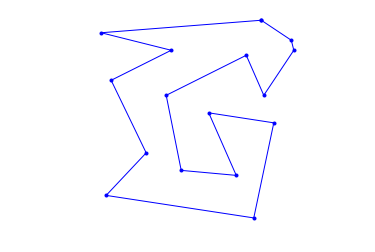

In [3]:
periodize = lambda gamma: concatenate((gamma, [gamma[0]]))
def cplot(gamma,s='b',lw=1): 
    plt.plot(real(periodize(gamma)), imag(periodize(gamma)), s, linewidth=lw)
    plt.axis('equal')
    plt.axis('off')
    
cplot(gamma0,'b.-');

Nombre de points de la courbe discrète (= nombre de segments)

In [4]:
p = 256

En fonction de la longueur d'un arc (ie: un segment), nous allons échantillonner différemment la courbe. Les lignes de code ci dessous permettent de définir des fonctions utilisées ensuite pour obtenir une courbe "lisse".


In [5]:
# interpc: fonction prenant trois arguments et donnant un complexe. La fonction interp de python interpole les vecteurs de
# données xf et real(yf) (ou imag(yf)) et évalue les valeurs obtenues en x.
interpc = lambda x,xf,yf: interp(x,xf,real(yf)) + 1j * interp(x,xf,imag(yf))
#curvabs: fonction prenant en entrée gamma (vecteur), puis retourne un vecteur commençant par 0 et la somme cumulée 
# de la différence entre gamma sans le premier terme et gamma sans le dernier terme
curvabs = lambda gamma: concatenate( ([0], cumsum( 1e-5 + abs(gamma[:-1:]-gamma[1::]) ) ) )

#arange(0,p) = vecteur de 0 à p-1 --> est bien composé de p points.
#resample1 calcule l'interpolation entre un vecteur de 0 à p-1 pris en entrée et normalisé et le vecteur d  divisé par
# d[-1] et gamma
resample1 = lambda gamma,d: interpc(arange(0,p)/float(p),  d/d[-1],gamma)
#periodize: fonction créée plus haut. Concatène le vecteur d'entrée avec sa première composante
resample = lambda gamma: resample1( periodize(gamma), curvabs(periodize(gamma)) )

#### Courbe initiale gamma 1

In [6]:
gamma1 = resample(gamma0)

#### Visualisation de la courbe initiale gamma 1

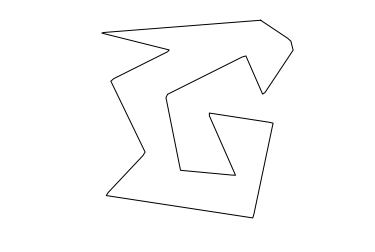

In [7]:
cplot(gamma1, 'k')

#### Différence finies
Décentrage en amont (forward differences: FwdDiff) et en aval (backward differences: BwdDiff).
Ces décentrages sont définis respectivement par: $\nabla f_p = f_{p+1} - f_p$ et $\nabla f_p = f_p - f_{p-1}$.

In [8]:
shiftG = lambda c: concatenate( ([c[-1]],c[:-1:]) ) #Décalage des données (en entrée de la fonction) vers la gauche
shiftD = lambda c: concatenate( (c[1::],[c[0]]) ) #Décalages des données vers la droite (donc dernier élement devient le premier)
BwdDiff = lambda c: c - shiftG(c) #grad f_p = f_p - f_{p-1}  avec f_{p-1} la courbe paramétrée avec p-1
FwdDiff = lambda c: shiftD(c) - c

#### Calcul de la tangente et de la normale à une courbe

In [9]:
normalize = lambda v: v/maximum(abs(v),1e-10) #normalisation, fonction maximum utilisée afin de ne pas diviser par 0
tangent = lambda gamma: normalize( FwdDiff(gamma) ) #par définition
normal = lambda gamma: -1j*tangent(gamma) #par définition

#### Déplacement de la courbe dans la direction de sa normale

In [10]:
delta = .03
gamma2 = gamma1 + delta * normal(gamma1) #dans la direction de la normale
gamma3 = gamma1 - delta * normal(gamma1) #dans la direction opposée à la normale

#### Visualisation

(0.09818192340611909,
 0.979037189504653,
 0.011000256259768859,
 0.942237845572892)

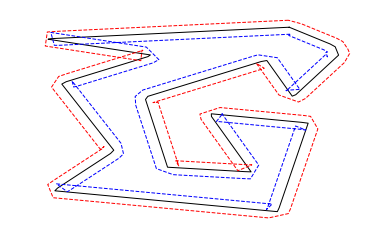

In [11]:
cplot(gamma1, 'k') #noir: courbe initiale lissée (après interpolation)
cplot(gamma2, 'r--') #rouge: direction de la normale --> courbe plus à l'extérieur
cplot(gamma3, 'b--') #bleu: direction opposée à la normale --> courbe à l'intérieur de la courbe initiale
plt.axis('tight') 
plt.axis('off')

 ### Evolution by mean curvature

On appelle évolution d'une courbe une série de courbes $\gamma_s$ indexées par un paramètre d'évolution $s$.
Afin d'évaluer la courbe intiale, dans notre cas: $\gamma_0$, il suffit de minimiser son énergie $E(\gamma)$ par une méthode de descente du gradient: $$\frac{\partial{\gamma}}{\partial{s}} = \nabla E(\gamma_s)$$

Chacune des courbes dans la série peut être pensée comme une surface de Riemann. Autrement dit, ce sont des variétés complexes de dimension 1 ou, de manière équivalente, des variétés différentielles de dimension 2.

La manière la plus simple d'obtenir l'évolution d'une courbe est la méthode de "mean curvature", que l'on peut traduire méthode de "courbure moyenne". Cela correspond à trouver la minimisation de la longueur de la courbe:
$$E(\gamma) = \int_0^1 ||\gamma ' (t)|| dt $$

Ce minimum sera trouvé grâce à la méthode de descente du gradient.

Le gradient de cette longueur est:
$$ \nabla E(\gamma)(t) = -K_\gamma(t) n_\gamma(t) $$

avec $K$ la courbure, définie par: $ K_\gamma(t) = \frac{1}{||\gamma'(t)||} <t'_\gamma(t),n_\gamma(t)>$


normalC est une fonction qui sera utilisée pour trouver le gradient $\nabla E(\gamma)(t)$.

In [12]:
normalC = lambda gamma: BwdDiff(tangent(gamma)) / abs( FwdDiff(gamma) )

Ci dessous: intervalle de temps avant une évolution, nombre maximal d'itérations et initialisation de de la courbe $\gamma_0$.

A cause de la forte courbure de la forme étudiée, nous devons choisir un intervalle de temps petit. Sinon, la méthode du gradient n'aboutirait pas à un bon résultat puisque $\gamma$ subirait des changements trop importants au cours de son évolution.

In [13]:
dt = 0.001 / 100

In [14]:
Tmax = 3.0 / 100
niter = round(Tmax/dt) #3000

$\gamma$ prend la valeur de $\gamma_1$, c'est à dire de la forme initialement étudiée, (cf en noir figure ci dessus).

In [15]:
gamma = gamma1

Evolution de la courbe $\gamma$

Cette évolution correspond à la méthode de descente du gradient : $$\gamma = \gamma - dt * \nabla E(\gamma)(t) = \gamma + dt * K_\gamma(t) n_\gamma(t)$$

In [16]:
gamma = gamma + dt * normalC(gamma)

Un échantillonnage de la courbe est appliqué afin paramétrer la vitesse d'évolution (la stabiliser). Une vitesse stabilisée permet de mener à bien la descente du gradient.

In [17]:
gamma = resample(gamma)

#### Exercice 1:  Perform the curve evolution. You need to resample it a few times.

Dans cet exercice, nous devons afficher l'évolution de la courbe paramétrique illustrée avant. Nous choisissons une évolution en 10 étapes, soit 10 courbes. Dans le résultat, la courbe bleue en pointillés la plus interne correspond à la dernière itération, tandis que la plus externe correspond à la première. Les 8 courbes rouges décrivent l'évolution de la courbe en allant de l'extérieur vers l'intérieur.

Sur 3000 itérations, c'est à dire sur 3000 échantillonages, 10 courbes seulement permettent de décrire une évolution. Grâce à celles-ci, il est possible de visualiser la descente du gradient. Classiquement, la méthode de descente du gradient converge de moins en moins vite vers un minimum. C'est le cas ici. Plus on s'éloigne de la courbe extérieure (première itération équivaut à la courbe bleue externe) moins l'écart entre les courbes est grand. Pourtant, nous avons utilisé un vecteur de 10 chiffres uniformément répartis entre 1 et 3000 pour l'affichage. Cela signifie bien que, pour un même nombre d'itérations, plus on approche d'un minimum plus la courbe a une faible évolution.

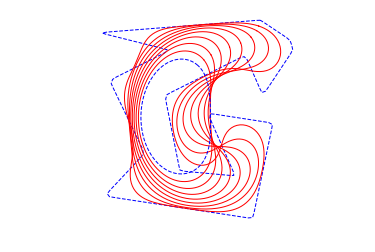

In [18]:
aff = np.around(linspace(1,niter,10)) #liste utilisée pour l'affichage. On veut avoir 10 courbes, d'où on initialise
#un vecteur de 10 valeurs espacées équitablement entre 1 et niter=3000.

k = 0 #initialisation de la variable parcourant aff

for i in range (1,niter+1): #1 à 3000
    gamma = resample(gamma + dt*normalC(gamma)) # échantillonage à chaque itération
    if i==aff[k] :
        if (i==1 or i==niter) :  #courbe la plus au centre ou plus à l'extérieur, ie: 1ère valeur de aff ou dernière
            cplot(gamma, 'b--') #alors on dessine en pointillés noirs
        else:
            cplot(gamma, 'r')
             #sinon on dessine en trait plein rouge          
        
        k = k+1

### Geodesic Active Contours

Le principe est le même que précédemment sauf que nous allons utiliser la longueur pondérée de la curvature. C'est pourquoi nous pouvons écrire la nouvelle énergie à minimiser:
$$E(\gamma) = \int_0^1 W(y(t))||\gamma ' (t)|| dt $$

$W > 0$ est une métrique géodésique, c'est à dire que ce sont les poids correspondant aux chemins les plus courts, si ils existent, entre deux points.
Là où l'image doit être segmentée, $W(x)$ sera petit.

In [19]:
n = 200 #taille de l'image

On créé un vecteur de poids et on le visualise.

Pour se faire on définit la variable $theta$ comme un tableau d'éléments à 1 coefficient aléatoirement choisis entre 0 et 1, puis multipliés par $2\pi$.



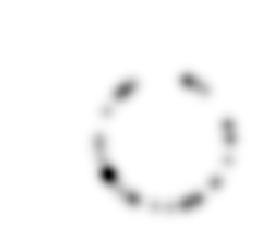

In [20]:
nbumps = 40
theta = random.rand(nbumps,1)*2*pi

r = .6*n/2 #rayon
a = np.array([.6*n,.6*n])

A0 = int(a[0]) + r*np.cos(theta) #en coordonnées cylindriques
A1 = int(a[1]) + r*np.sin(theta) 

x = around(A0) #pour avoir des coordonnées entières
y = around(A1)

W = zeros([n,n]) #40*40
for i in arange(0,nbumps): #i:0:40
    W[int(x[i]),int(y[i])] = 1 #coeff de W prennent la valeur de 1 lorsque correspondent à des données sur le cercle?....
    
W = gaussian_blur(W,6.0) #filtre gaussien appliqué pour le floutage
W = rescale(-minimum(W,.05), .3,1)

#Visualisation
imageplot(W)

On cherche désormais à visualiser la norme du gradient des poids: $||\nabla W||$.

La norme du gradient est très utilisée afin de déterminer des contours dans des images. En effet, le contour est situé au niveau des maximas locaux repérés dans la direction du gradient. A REOVIR SI ON MET --> je pense pas enfait

In [21]:
G = grad(W) #calcul du gradient
G = G[:,:,0] + 1j*G[:,:,1] #Laura ici tu vas pouvoir nous aider ;)    Je sais plus ce que ça fait l'ajout du dernier indice

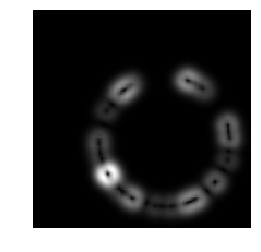

In [22]:
imageplot(abs(G))

L'image ci-dessus paraît complémentaire à l'image précédemment visualisée. Les parties avec plus ou moins d'intensité coïncident dans les deux images.

Définitions de fonctions pour évaluer le gradient et le potentiel le long d'une courbe.

In [23]:
EvalG = lambda gamma: bilinear_interpolate(G, imag(gamma), real(gamma))
EvalW = lambda gamma: bilinear_interpolate(W, imag(gamma), real(gamma))

Création courbe circulaire $\gamma_0$.

In [24]:
r = .98*n/2 #rayon
p = 128 #nombre de points sur la courbe
theta = transpose( linspace(0, 2*pi, p+1) )#transposée d'un vecteur de longueur p+1 allant de 0 à 2pi (intervalles égaux)
theta = theta[0:-1] #sans la derniere valeur, car cos(0)=cos(2pi) et idem pour sin
gamma0 = n/2 * (1 + 1j) +  r*(np.cos(theta) + 1j*np.sin(theta)) #courbe circulaire

Initialisation.

In [25]:
gamma = gamma0 #initialisation de la série de courbe avec gamma0 (courbe circulaire)

In [26]:
dt = 1 #intervalle de temps. Plus grand car courbe appartient à [0,n-1]*[0,n-1]
Tmax = 5000 #max temps
niter = round(Tmax/ dt) #nombre d'itérations

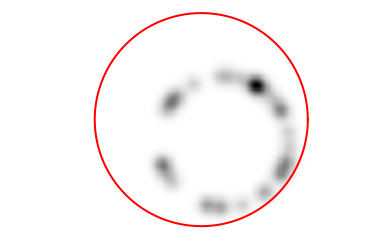

In [27]:
lw = 2 #largeur trait
plt.clf
imageplot(transpose(W)) #visualisation des poids
cplot(gamma, 'r', lw) #visualisation de la courbe

Pour cette courbe, le gradient de l'énergie est :
$$ \nabla E(\gamma) = -W(\gamma(t)) K_\gamma(t)n_\gamma(t)  + <\nabla W(\gamma(t)),n_\gamma(t)> n_\gamma(t). $$

Le produit scalaire est défini par la fonction ci dessous.

In [28]:
dotp = lambda c1,c2: real(c1)*real(c2) + imag(c1)*imag(c2) #produit scalaire

Evaluation de la courbe.

Pour se faire, rappelons que :

EvalW(gamma) correspond à $W(\gamma(t))$,

normalC(gamma) correspond à $K_\gamma(t)n_\gamma(t)$,

dotp(EvalG(gamma), N) correspond à $<\nabla W(\gamma(t)),n_\gamma(t)> $,

et enfin normal(gamma) correspond à $n_\gamma(t)$, la normale.

In [29]:
N = normal(gamma)
g = - EvalW(gamma) * normalC(gamma) + dotp(EvalG(gamma), N) * N
gamma = gamma - dt*g

In [30]:
gamma = resample(gamma) #échantillonage

#### Exercise 2: Perform the curve evolution.

Nous implémentons dans cette exercice l'évolution du cercle rouge. Nous utilisons la même méthode que dans le premier exercice. Le principe est d'utiliser un vecteur de 10 coefficients (pour les 10 courbes ou 10 étapes d'évolution) uniformément répartis entre 1 et le nombre d'itérations. Le but est en quelque sorte d'"immortaliser" l'évolution de la courbe à certaines étapes (ici: 10 à intervalles de temps égaux).On effectue la méthode de descente du gradient pour chacune des itérations, et on affichage le stade de l'évolution lorsque l'on rencontre une étape. L'immortalisation se traduit par l'affichage d'une courbe rouge. 

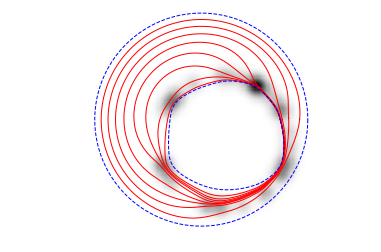

In [31]:
aff = around(linspace(1,niter,10)) #affichage de 10 courbes
k = 0
plt.clf
imageplot(transpose(W))
for i in range(1,niter+1):
    N = normal(gamma)
    g = -EvalW(gamma)*normalC(gamma) + dotp(EvalG(gamma),N)*N
    gamma = resample(gamma - dt*g)  #échantillonage à chaque boucle  
    if i==aff[k]:
        if (i==1 or i==niter):
            cplot(gamma, 'r',lw) #pour courbes extrémités
        else:
            cplot(gamma, 'r') #pour courbes internes

        k = k+1


### Medical Image Segmentation

Il est aussi possible d'utiliser une métrique basée sur une étude de gradient pour détecter des contours. Appliquons cette méthode sur une image médicale par exemple.

/home/cmoriceau/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/cmoriceau/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


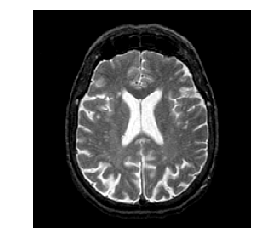

In [32]:
n = 256
name = 'nt_toolbox/nt_toolbox/data/cortex.bmp' # A Revoir pour faire avec chemin relatif
f = load_image('cortex.bmp', n) #download image
imageplot(f) #affichage

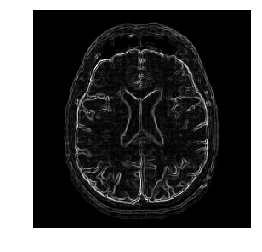

In [33]:
G = grad(f) #calcul du gradient de l'image
d0 = np.sqrt(sum(G**2, 2)) #calcul de la norme 2 du gradient
imageplot(d0) #affichage

Ce détecteur de contour est une fonction de la magnitude du gradient et est décroissante. Nous allons tout d'abord flouter l'image par un facteur $a$. Le floutage peut être vu comme la multiplication de la matrice composée de pixels (l'image) et de la matrice de floutage (la matrice gaussienne et divisée par le coefficient $a$).

Par exemple voici une matrice de floutage de type gaussien (dimension 3):
$$ \frac{1}{a}
\begin{bmatrix}
1 & 2 & 1 \\
2 & 4 & 2 \\
1 & 2 & 1
\end{bmatrix}$$

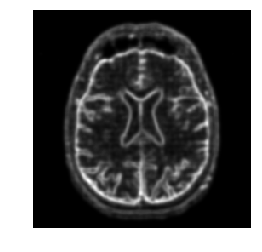

In [34]:
a = 2 #coefficient de floutage
d = gaussian_blur(d0, a) #d0 image initiale --> floutage gaussien appliqué avec coefficient a
imageplot(d) #affichage

In [35]:
d = minimum(d, .4) #minimum entre les valeurs après floutage et 0.4
W = rescale(-d, .8, 1) #redéfinition des poids W

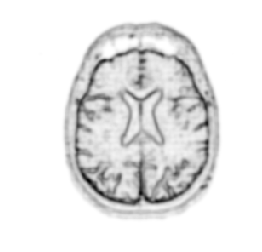

In [36]:
imageplot(W) #affichage des poids une fois redéfinis

Nombre de points

In [37]:
p = 128 #nombre de points sur la courbe

#### Exercise 3: Create an initial circle $\gamma_0$ of $p$ points. When plotting the image, you need to transpose it to have axis coherent with the cplot.

La courbe initiale est le cercle rouge.

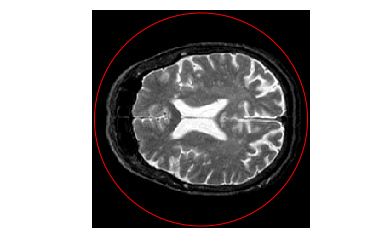

In [38]:
#redéfinition du rayon et de theta (car n a changé), idem pour gamma0
r = .98*n/2;
theta = transpose(linspace(0,2*pi,p+1))
theta = theta[0:-1] #sans derniere valeur (toujours car cos(0)=cos(2pi))
gamma0 = n/2*(1 + 1j) +  r*(np.cos(theta) + 1j*np.sin(theta)) #première courbe = cercle

#affectation
gamma = gamma0; #initialisation de l'évolution
#affichage
plt.clf
imageplot(transpose(f)) #transposée de l'image selon la consigne
cplot(gamma,'r')

Passons à la visualisation de l'évolution de la courbe.

In [39]:
dt = 2 #intervalle de temps

In [40]:
Tmax = 9000 #temps max
niter = round(Tmax/ dt) #nombre max d'itérations

#### Exercise 4: Perform the curve evolution.

A nouveau, nous appliquons le même raisonnement pour calculer l'évolution de la courbe.
A chaque itération nous ré-évaluons $\gamma$ et nous l'affichons à 10 étapes équitablement réparties tout au long de l'évolution.

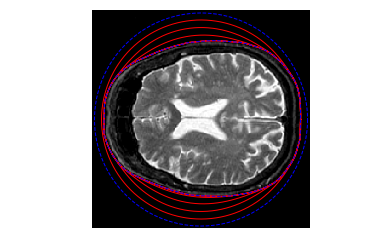

In [41]:
#on était restés à G=grad(f)
G = G[:,:,0] + 1j*G[:,:,1] #IDEM: Laura ici tu vas pouvoir nous aider ;) Je sais plus ce que ça fait l'ajout du dernier indice

aff = around(linspace(1,niter,10))
k = 0
plt.clf
imageplot(transpose(f))
for i in range(1,niter+1):
    N = normal(gamma)
    g = -EvalW(gamma)*normalC(gamma) + dotp(EvalG(gamma), N)*N #réutilisation de EvalW et EvalG (définis avant)
    gamma = resample(gamma - dt*g) #échantillonage à chaque itération 
    if i==aff[k]:
        if (i==1 or i==niter):
            cplot(gamma, 'b--')
        else:
            cplot(gamma, 'r')
            
        k = k+1

### Evolution of a Non-closed Curve

Pour finir nous allons étudier les courbes non fermées. Afin d'afficher leur évolution il faut introduire des conditions aux frontières. Nommons par exemples ces deux contraintes:
$\gamma(0) = x_0$ et $\gamma(1) = x_1$.

/home/cmoriceau/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/cmoriceau/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


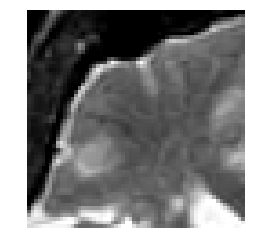

In [42]:
n = 256
f = load_image('cortex.bmp', n)
f = f[45:105, 60:120] #on étudie seulement une partie de l'image
n = f.shape[0] #n prend la valeur du nombre de lignes de la matrice de pixels (égale ici au nombre de colonnes = 60)

#affichage du carré de l'image étudié
imageplot(f)

#### Exercise 5: Compute an edge attracting criterion W(x)>0, that is small in area of strong gradient.

Le but de cet exercice est d'obtenir l'image précédemment affichée avec des intensités différentes en fonction du gradient. Ainsi, on aura bien une image où les contours pourront être plus facilement repérés.

Nous calculons dans un premier temps le gradient de l'image et sa norme. L'idée est ensuite d'accentuer au maximum les propriétés de l'image pour détecter plus facilement les contours. Pour se faire nous filtrons l'image (convolution) par un filtre gaussien. Enfin, nous souhaitons un critère de détection de bords petit là où le gradient est grand. C'est pourquoi nous donnons la valeur de 0.3 à chacun des pixels où le gradient serait plus élevé que ce seuil.

Pour affiner le critère de détection, il suffirait alors de diminuer le seuil de tolérance. En prenant par exemple un seuil à 0.2, la visualisation des poids amène à un bord nettement plus distinct. Un seuil de tolérance trop bas n'est en revanche d'aucune utilité. Cela mène à une image où les bords sont très épais. Ceci n'a aucun intérêt car alors, en poussant ce problème à sa limite, toute l'image deviendrait un bord. Nous pouvons noter que ce phénomène d'élargissement progressif des contours est dû au filtre gaussien convolué avant à l'image. Le seuil devenant de plus en plus petit il est normal que de moins en moins de valeurs y soit inférieures.

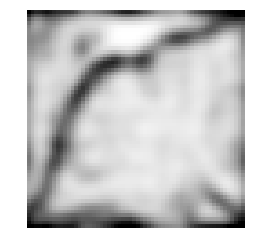

In [43]:
#gradient de f
G = grad(f)
#G0 : norme 2 du gradient
G0 = np.sqrt(sum(G**2, 2))
G = gaussian_blur(G0,a) #afin d'accentuer les valeurs dans l'image (--> filtre gaussien)
G = minimum(G,.3) #0.3 si "strong gradient" ie: dans les régions où G est elevé alors G prendra la valeur de 0.3 (petit)
W = rescale(-G,.4,1)
plt.clf
imageplot(W)

Définition des contraintes: $x_0$ et $x_1$.

In [44]:
x0 = 4 + 55j
x1 = 53 + 4j

In [45]:
p = 128 #nombre de points de la courbe
t = transpose(linspace(0, 1, p))
gamma0 = t*x1 + (1-t)*x0 #premiere courbe

In [46]:
gamma = gamma0 #initialisation de l'évolution avec la courbe initiale

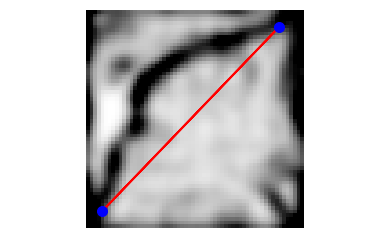

In [47]:
plt.clf
imageplot(transpose(W))
cplot(gamma,'r', 2)
plt.plot(real(gamma[0]), imag(gamma[0]), 'b.', markersize=20)
plt.plot(real(gamma[-1]), imag(gamma[-1]), 'b.', markersize=20);

Définitions de fonctions pour les courbes non périodiques.

In [48]:
curvabs = lambda gamma: concatenate( ([0], cumsum( 1e-5 + abs(gamma[:-1:]-gamma[1::]) ) ) )
resample1 = lambda gamma,d: interpc(arange(0,p)/float(p-1),  d/d[-1],gamma)
resample = lambda gamma: resample1( gamma, curvabs(gamma) )

In [49]:
dt = 1/10 #intervalle de temps
Tmax = 2000*4/ 7
niter = round(Tmax/ dt) #nombre maximal d'itérations

#### Exercise 6: Perform the curve evolution. Be careful to impose the boundary conditions at each step.

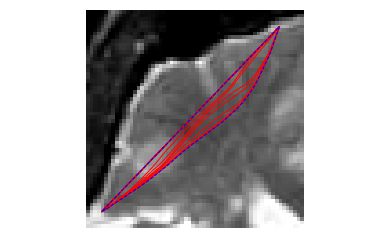

In [50]:
G = grad(f) #gradient de f
G = G[:,:,0] + 1j*G[:,:,1]

aff = around(linspace(1,niter,10))

k = 0
plt.clf
imageplot(f)

for i in range(1,niter+1):
    N = normal(gamma)
    g = -EvalW(gamma)*normalC(gamma) + dotp(EvalG(gamma),N)*N
    gamma = resample(gamma - dt*g) #échantillonage à chaque itération
    gamma[0] = x0
    gamma[-1] = x1 #contraintes aux frontières à ajouter à chaque itération
    if i==aff[k]:
        if (i==1 or i==niter):
            cplot(gamma, 'b--')
        else:
            cplot(gamma, 'r')
        k = k+1